# Week 1

- Calculate performance metrics of the model output compared to the truth values 

In [45]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


sns.set_style("darkgrid")

In [46]:
df_raw = pd.read_csv("helena_results.csv")
df_raw.head()

,file,x1,x2,y1,y2,mask,date,start_time,frame no,quadrant,true_mask
0,park-tests/converted/coverted_FRAMES/20210526_...,720,763,185,246,0,20210526,182313,1248,3,0
1,park-tests/converted/coverted_FRAMES/20210526_...,13,40,3,40,1,20210526,182313,4876,3,1
2,park-tests/converted/coverted_FRAMES/20210526_...,695,736,201,254,0,20210526,182313,4876,3,0
3,park-tests/converted/coverted_FRAMES/20210526_...,573,663,326,430,1,20210526,182313,4397,1,1
4,park-tests/converted/coverted_FRAMES/20210526_...,893,973,346,452,1,20210526,182313,4397,1,1


In [47]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1038 entries, 0 to 1037
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   file        1038 non-null   object
 1   x1          1038 non-null   int64 
 2   x2          1038 non-null   int64 
 3   y1          1038 non-null   int64 
 4   y2          1038 non-null   int64 
 5   mask        1038 non-null   int64 
 6   date        1038 non-null   int64 
 7   start_time  1038 non-null   int64 
 8   frame no    1038 non-null   int64 
 9   quadrant    1038 non-null   int64 
 10  true_mask   1038 non-null   int64 
dtypes: int64(10), object(1)
memory usage: 89.3+ KB


## Definitions
**mask:** model output

**true_mask:** true label (human labeled)

- 0: mask
- 1: no-mask
- 2: false detection

A **false detection** describes an instance where the model detected the ground, or other object, as a face.

## Data Cleaning and Filtering

In [48]:
df_raw['mask'].value_counts()

0    707
1    331
Name: mask, dtype: int64

In [49]:
df_raw['true_mask'].value_counts()

1    530
0    447
2     61
Name: true_mask, dtype: int64

In [50]:
pd.crosstab(df_raw['mask'], df_raw['true_mask'], margins=True)

true_mask,0,1,2,All
mask,,,,
0,357,302,48,707
1,90,228,13,331
All,447,530,61,1038


**Currently, the binary classes are 0 = mask, 1 = no_mask**

**Want to invert these values so that 1 = mask, 0 = no_mask**

**We will also filter out all rows where there was a false detection (true_mask = 2)**

In [51]:
# create a copy of the raw dataframe
df_filtered = df_raw.copy()

In [52]:
# exclude false detections from this analysis
df_filtered = df_filtered[df_filtered['true_mask'] < 2]
df_filtered.shape

(977, 11)

In [53]:
df_filtered['mask'] = np.where(df_filtered['mask'] == 1, 0, 1)
df_filtered['true_mask'] = np.where(df_filtered['true_mask'] == 1, 0, 1)

In [54]:
pd.crosstab(df_filtered['mask'], df_filtered['true_mask'], margins=True)

true_mask,0,1,All
mask,,,
0,228,90,318
1,302,357,659
All,530,447,977


**As we can see, the mask and true mask classes are now inverted and ready for analysis**

## Metrics and Scoring

In [55]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

<div>
<img src="Metrics/Sensitivityspecificity.png" width="300"/>
<img src="Metrics/Precisionrecall.png" width="300"/>
</div>

- sensitivity = P(predicting mask | wearing mask)
- specificity = P(preditcing no mask | not wearing mask)

As we can see from the image above, Sensitivity and Recall are the same metric

**This analysis will be limited to the following metrics:**

- Sensitivity 
- Specificity
- Precision
- Accuracy

In [56]:
def sensitivity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tp/(tp+fn)

def specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn/(tn+fp)

In [57]:
metric_functions = {'sensitivity': sensitivity, 
                    'specificity': specificity,
                    'precision': precision_score,
                    'accuracy': accuracy_score}

metric_values = {}

for metric in metric_functions:
    score = metric_functions[metric](y_true=df_filtered['true_mask'], y_pred=df_filtered['mask'])
    print(f'{metric} score: {round(score, 4)}')
    metric_values[metric] = round(score, 4)

sensitivity score: 0.7987
specificity score: 0.4302
precision score: 0.5417
accuracy score: 0.5988


# Week 2

- Calculate confidence intervals around these numbers
- Two sample testing of accuracy metrics - testing specificity between different groups, p values 
- Look at different groups where the metrics are better/worse
    - look for big spreads
    
- Nirmal - worked with Ted
- Ted Morris (camera / robotics, etc)
    - Camera has object detection capabilities
    
- Helena - worked with Catherine Zhao
    - Graduated and developed NN
    
- Catherine Zhao
    - Reach out to Catherine for training data / model code
    - Hoping to get access to the code / training data
    - Willing to put them on github with prof wolfson

## Exploration

- explore rnn for image classification since it has a memory component and looks at multiple frames at once

## Calculating confidence intervals around the metrics

### Z-score

In [58]:
def confidence_interval_z_score(n, metric):
    # standard error
    se = np.sqrt(metric * (1-metric) / n)
    
    # z score for 95% confidence interval
    z = stats.norm.ppf(0.975)
    
    lower = metric - z*se
    upper = metric + z*se
    
    return (round(lower, 4), round(upper, 4))

In [59]:
n = df_raw.shape[0]
for metric in metric_values:
    metric_value = metric_values[metric]
    ci = confidence_interval_z_score(n, metric_value)
    print(f'95% confidence interval for the {metric} of {metric_value} is: {ci} \n')

95% confidence interval for the sensitivity of 0.7987 is: (0.7743, 0.8231) 

95% confidence interval for the specificity of 0.4302 is: (0.4001, 0.4603) 

95% confidence interval for the precision of 0.5417 is: (0.5114, 0.572) 

95% confidence interval for the accuracy of 0.5988 is: (0.569, 0.6286) 



**Turns out, using the z score method for some metrics may not be adequate**

Since the denominator is n, the number of records. This will work for something like the average (since the denominator is the same), but for metrics like specificity and sensitivity, the denominator isn't - so a method like bootstrapping will work better.

### Bootstrapping

In [60]:
from sklearn.utils import resample

def confidence_interval_bootstrapping(y_true, y_pred, metric_function, n_iterations=100, alpha=0.05):
    
    metric_samples = []
    
    for i in range(n_iterations):
        y_true_resample, y_pred_resample = resample(y_true, y_pred)
        metric_resample = metric_function(y_true_resample, y_pred_resample)
        metric_samples.append(metric_resample)
        
    lower = np.percentile(metric_samples, alpha/2*100)
    upper = np.percentile(metric_samples, (1-alpha/2)*100)
    
    return (round(lower, 4), round(upper, 4))

def get_bootstrapping_ci(df):
    
    mask_true = df['true_mask']
    mask_pred = df['mask']
    
    metrics_ci = {'Metric': [],
                  'Score': [],
                  'Lower bound': [],
                  'Upper bound': [],
                  'Error': []}
    
    metric_functions = {'sensitivity': sensitivity, 
                        'specificity': specificity,
                        'precision': precision_score,
                        'accuracy': accuracy_score}

    metric_values = {}

    for metric in metric_functions:
        metrics_ci['Metric'].append(metric)

        metric_value = metric_functions[metric](y_true=mask_true, y_pred=mask_pred)
        metric_value = round(metric_value, 4)
        metrics_ci['Score'].append(metric_value)

        ci = confidence_interval_bootstrapping(mask_true, mask_pred, metric_functions[metric])
        metrics_ci['Lower bound'].append(ci[0])
        metrics_ci['Upper bound'].append(ci[1])
        
        metrics_ci['Error'].append((round(metric_value-ci[0], 4), round(ci[1]-metric_value, 4)))
    
    return pd.DataFrame(metrics_ci)
    
    

In [61]:
# list to hold dataframes containing metrics from different groups
df_groups = []

In [62]:
metrics_df = get_bootstrapping_ci(df_filtered)
metrics_df['Group'] = 'All'
df_groups.append(metrics_df)

print("Metrics for all groups:\n")
metrics_df[['Metric', 'Score', 'Lower bound', 'Upper bound']]

Metrics for all groups:



,Metric,Score,Lower bound,Upper bound
0,sensitivity,0.7987,0.7678,0.8311
1,specificity,0.4302,0.3994,0.4700
2,precision,0.5417,0.5045,0.5766
3,accuracy,0.5988,0.5659,0.6301


# Week 3
- Look into bootstrap pros and cons
- Get this in a table for now
- For future - look at sub groups - plot on same plot
- Gor now, stick with metrics like sensitivity and specificity since they don't depend on prevalance of the event
- Meet with ted and nermel

## Comparing metric scores across groups

### Frame Quadrants

In [63]:
df_filtered['quadrant'].value_counts()

1    534
3    443
Name: quadrant, dtype: int64

#### After filtering data, all bounding boxes in quadrants 1 and 3

In [64]:
pd.crosstab(df_filtered['mask'], df_filtered['quadrant'], margins=True)

quadrant,1,3,All
mask,,,
0,225,93,318
1,309,350,659
All,534,443,977


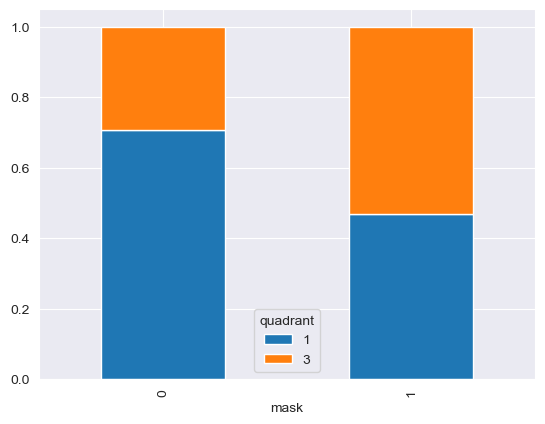

In [65]:
pd.crosstab(df_filtered['mask'], df_filtered['quadrant'], normalize='index').plot.bar(stacked=True)
plt.show()

#### Most no-mask detections (mask = 0) were found in quadrant 1

- Quadrant 1 contains 534/977 ~ 55% of records

In [66]:
df_q1 = df_filtered[df_filtered['quadrant'] == 1]
metrics_df_q1 = get_bootstrapping_ci(df_q1)
metrics_df_q1['Group'] = 'Q1'
df_groups.append(metrics_df_q1)

#### Most mask detections (mask = 1) were found in quadrant 3

- Quadrant 3 contains 443/977 ~ 45% of records

In [67]:
df_q3 = df_filtered[df_filtered['quadrant'] == 3]
metrics_df_q3 = get_bootstrapping_ci(df_q3)
metrics_df_q3['Group'] = 'Q3'
df_groups.append(metrics_df_q3)

#### Comparing Quadrants

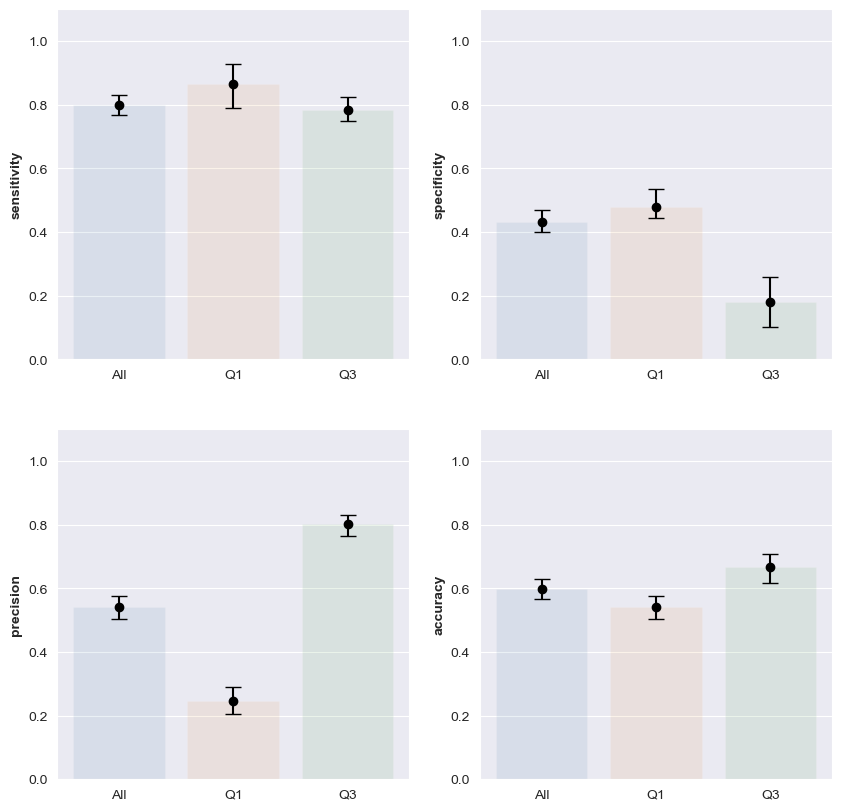

In [68]:
df_concat = pd.concat(df_groups, ignore_index=True)

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
axs = np.array(ax).flatten()
i = 0

for metric in metric_functions:
    df_metric = df_concat[df_concat['Metric'] == metric]
    df_metric.reset_index(drop=True, inplace=True)
    
    sns.barplot(data=df_metric, x='Group', y='Score', alpha=0.1, ax=axs[i])
    y_error = np.array(list(df_metric['Error'])).T
    axs[i].errorbar(x=df_metric.index, y=df_metric['Score'], yerr=y_error, fmt='o', ecolor='black', color='black', capsize=6)
    
    axs[i].set_xlabel('')
    axs[i].set_ylabel(metric, fontweight='bold')
    i += 1

plt.setp(ax, ylim=[0, 1.1])
plt.show()

### Exploring Dates

In [69]:
df_filtered.columns

Index(['file', 'x1', 'x2', 'y1', 'y2', 'mask', 'date', 'start_time',
       'frame no', 'quadrant', 'true_mask'],
      dtype='object')

In [70]:
df_filtered.shape

(977, 11)

In [71]:
df_filtered['date'].value_counts()

20210526    762
20210614    186
20210618     29
Name: date, dtype: int64

In [72]:
df_filtered['start_time'].value_counts()

182313    570
154716    186
163653    112
170716     41
165204     39
151458     29
Name: start_time, dtype: int64

In [73]:
pd.crosstab(df_filtered['start_time'], df_filtered['date'], margins=True, margins_name='Total')

date,20210526,20210614,20210618,Total
start_time,,,,
151458,0,0,29,29
154716,0,186,0,186
163653,112,0,0,112
165204,39,0,0,39
170716,41,0,0,41
182313,570,0,0,570
Total,762,186,29,977


- **Three days are present in the filtered dataset.**
- **Six start times are present in the filtered dataset, with 20210526 being the only date with more than one start time.**

In [74]:
pd.crosstab(df_filtered['mask'], df_filtered['date'], margins=True, margins_name='Total')

date,20210526,20210614,20210618,Total
mask,,,,
0,256,48,14,318
1,506,138,15,659
Total,762,186,29,977


In [75]:
pd.crosstab(df_filtered['true_mask'], df_filtered['date'], margins=True, margins_name='Total')

date,20210526,20210614,20210618,Total
true_mask,,,,
0,355,158,17,530
1,407,28,12,447
Total,762,186,29,977


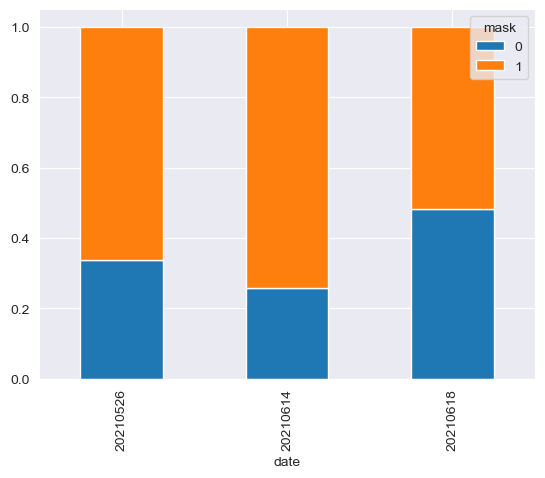

In [76]:
pd.crosstab(df_filtered['date'], df_filtered['mask'], normalize='index').plot.bar(stacked=True)
plt.show()

#### Date Analysis

- 2021 05 26
    - 65-35 split mask-no_mask
- 2021 06 14 
    - 70-30 split mask-no_mask
- 2021 06 18 
     - 50-50 split mask-no_mask

In [77]:
# reset groups df
df_groups = [metrics_df]

In [78]:
df_20210526 = df_filtered[df_filtered['date'] == 20210526]
metrics_df_20210526 = get_bootstrapping_ci(df_20210526)
metrics_df_20210526['Group'] = '20210526'
df_groups.append(metrics_df_20210526)

In [79]:
df_20210614 = df_filtered[df_filtered['date'] == 20210614]
metrics_df_20210614 = get_bootstrapping_ci(df_20210614)
metrics_df_20210614['Group'] = '20210614'
df_groups.append(metrics_df_20210614)

In [80]:
df_20210618 = df_filtered[df_filtered['date'] == 20210618]
metrics_df_20210618 = get_bootstrapping_ci(df_20210618)
metrics_df_20210618['Group'] = '20210618'
df_groups.append(metrics_df_20210618)

#### Comparing Dates

In [81]:
df_concat = pd.concat(df_groups, ignore_index=True)
df_concat[df_concat['Metric'] == 'accuracy']

,Metric,Score,Lower bound,Upper bound,Error,Group
3,accuracy,0.5988,0.5659,0.6301,"(0.0329, 0.0313)",All
7,accuracy,0.6549,0.6259,0.6870,"(0.029, 0.0321)",20210526
11,accuracy,0.3871,0.3198,0.4573,"(0.0673, 0.0702)",20210614
15,accuracy,0.4828,0.3103,0.6552,"(0.1725, 0.1724)",20210618


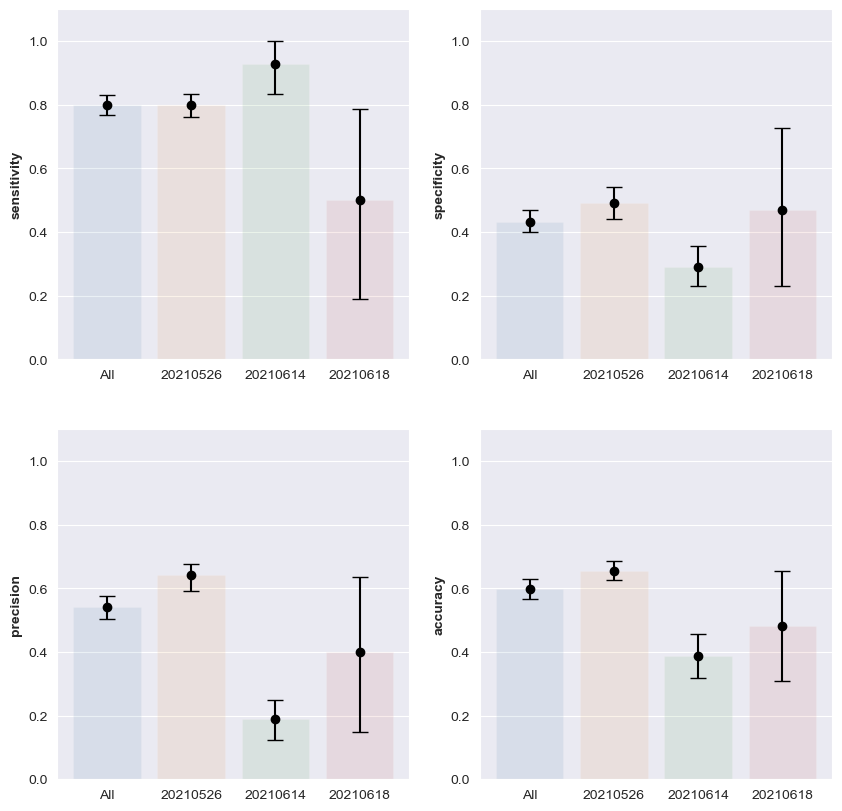

In [82]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
axs = np.array(ax).flatten()
i = 0

for metric in metric_functions:
    df_metric = df_concat[df_concat['Metric'] == metric]
    df_metric.reset_index(drop=True, inplace=True)
    
    sns.barplot(data=df_metric, x='Group', y='Score', alpha=0.1, ax=axs[i])
    y_error = np.array(list(df_metric['Error'])).T
    axs[i].errorbar(x=df_metric.index, y=df_metric['Score'], yerr=y_error, fmt='o', ecolor='black', color='black', capsize=6)
    
    axs[i].set_xlabel('')
    axs[i].set_ylabel(metric, fontweight='bold')
    i += 1

plt.setp(ax, ylim=[0, 1.1])
plt.show()

#### Some interesting results across days

- 05/26/2021
    - 59 degrees F and Sunny
- 06/14/2021
    - 84 degrees F and Sunny
- 06/18/2021
    - 86 degrees F and Sunny

-> All days warm and sunny

### Confidence intervals comparisons:

- if the intervals of two subgroups do not overlap, it suggests that there is a major significant difference between the subgroups.
- if the mean does not overlap with the interval of another subgroup, it suggests that there is a significant statistical difference also, depending on how you set up your hypothesis test


# Week 4

- Separate out images that have been classified as mask=0, and look at them

- Q1 -> Q3 transition seems important

- Group by quadrant/day

- Explore ways to improve model based on these insights

### Helena Convo

- Ingrid Schnider
    - parks and forestry - supportive of the project
- Ted Morris
    - data collection in the parks
- Catherine Zhao and Helena (robotics MS)
    - Proof of concept
    - CV model annotations and detections
    - Collected data from internet, collected and trained a few models
    - Image search is where images were from
    - Helena's project proved that the dataset is best one for mask detection
    - Says CV techniques is a good solution for this problem
    - Also says that the dataset is better than the existing mask datasets out there
    - Need to optimize the models
    - Also has depth data and could track frame by frame spacial analysis to get the face
    - Helena code first detects the face, then feeds the face into the mask classifier

### Frame Quadrants / Date Grouping

In [87]:
# reset groups df
df_groups = []

In [88]:
quadrants = [1, 3]
dates = [20210526, 20210614]

for d in dates:
    for q in quadrants:
        df_q_d = df_filtered[(df_filtered['quadrant'] == q) & (df_filtered['date'] == d)]
        metrics_df_q_d = get_bootstrapping_ci(df_q_d)
        metrics_df_q_d['Group'] = f'Q{q}_{d}'
        df_groups.append(metrics_df_q_d)

/var/folders/qk/p_zbkww15t9_4fk2_nm3_gp40000gn/T/ipykernel_6359/3385842869.py:3: RuntimeWarning: invalid value encountered in long_scalars
  return tp/(tp+fn)
/var/folders/qk/p_zbkww15t9_4fk2_nm3_gp40000gn/T/ipykernel_6359/3385842869.py:3: RuntimeWarning: invalid value encountered in long_scalars
  return tp/(tp+fn)
/var/folders/qk/p_zbkww15t9_4fk2_nm3_gp40000gn/T/ipykernel_6359/3385842869.py:3: RuntimeWarning: invalid value encountered in long_scalars
  return tp/(tp+fn)
/var/folders/qk/p_zbkww15t9_4fk2_nm3_gp40000gn/T/ipykernel_6359/3385842869.py:3: RuntimeWarning: invalid value encountered in long_scalars
  return tp/(tp+fn)
/var/folders/qk/p_zbkww15t9_4fk2_nm3_gp40000gn/T/ipykernel_6359/3385842869.py:3: RuntimeWarning: invalid value encountered in long_scalars
  return tp/(tp+fn)
/var/folders/qk/p_zbkww15t9_4fk2_nm3_gp40000gn/T/ipykernel_6359/3385842869.py:3: RuntimeWarning: invalid value encountered in long_scalars
  return tp/(tp+fn)


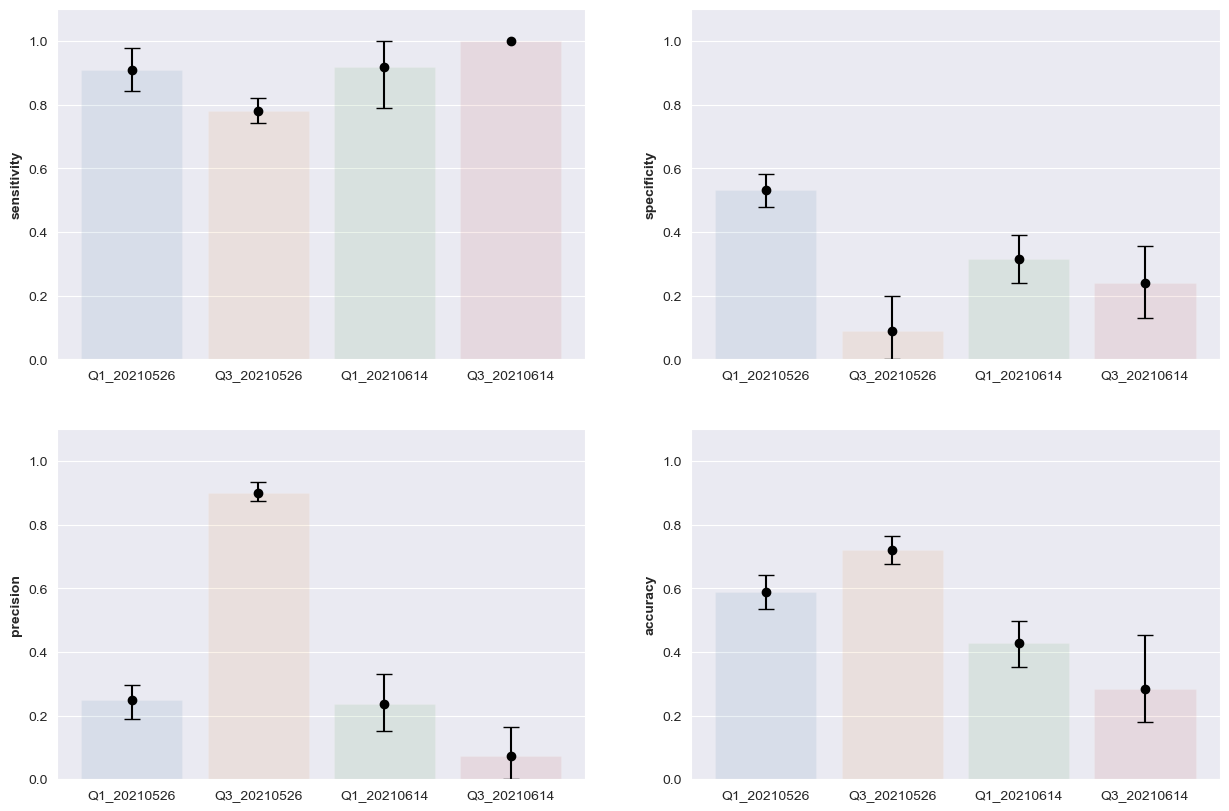

In [89]:
df_concat = pd.concat(df_groups, ignore_index=True)

fig, ax = plt.subplots(2, 2, figsize=(15, 10))
axs = np.array(ax).flatten()
i = 0

for metric in metric_functions:
    df_metric = df_concat[df_concat['Metric'] == metric]
    df_metric.reset_index(drop=True, inplace=True)
    
    sns.barplot(data=df_metric, x='Group', y='Score', alpha=0.1, ax=axs[i])
    y_error = np.array(list(df_metric['Error'])).T
    axs[i].errorbar(x=df_metric.index, y=df_metric['Score'], yerr=y_error, fmt='o', ecolor='black', color='black', capsize=6)
    
    axs[i].set_xlabel('')
    axs[i].set_ylabel(metric, fontweight='bold')
    i += 1

plt.setp(ax, ylim=[0, 1.1])
plt.show()

In [93]:
df_filtered[(df_filtered['quadrant'] == 3) & (df_filtered['date'] == 20210614) & (df_filtered['true_mask'] == 1)]

,file,x1,x2,y1,y2,mask,date,start_time,frame no,quadrant,true_mask
117,park-tests/converted/coverted_FRAMES/20210614_...,17,36,227,252,1,20210614,154716,5255,3,1
376,park-tests/converted/coverted_FRAMES/20210614_...,0,13,226,250,1,20210614,154716,5266,3,1
446,park-tests/converted/coverted_FRAMES/20210614_...,20,41,229,257,1,20210614,154716,6114,3,1


## Bucketing Images for Visual Analysis

In [86]:
images_mask_predicted = df_filtered[df_filtered['mask'] == 0]
file_names = list(images_mask_predicted['file'].str.split('/').str[-1])